<a href="https://colab.research.google.com/github/jobellet/fast_and_rich_decoding_in_VLPFC/blob/main/monkeyA_PFC_VS_PPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats
import numpy.matlib
from skimage.measure import label
import seaborn as sb
from tqdm import tqdm


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = "Arial"
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# functions for loading data
# functions for loading data
def get_monkeyA_df():
    try:
        df = pd.read_pickle('monkeyA.pkl')
    except:
        link_to_monkeyA_data = 'https://figshare.com/ndownloader/files/27869238'
        urllib.request.urlretrieve(link_to_monkeyA_data,'monkeyA.pkl')
        df = pd.read_pickle('monkeyA.pkl')
    return df

# functions for PSTH
def getSpikemat(spiketimes,mint=-.1,maxt=.4):
    '''
    Bin spiketimes at 1 kHz, single stimuli / trials
    '''
    t_total = int((maxt-mint)*1000) # total time bins
    nch = len(spiketimes)
    spikemat = np.zeros((nch,t_total)).astype(bool)
    for ch in range(nch):
        tms = np.round(spiketimes[ch]*1000).astype(int) - 1 #0-indexing
        
        tms = tms[(tms>=mint*1000) & (tms<maxt*1000)] - int(mint*1000)
        if len(tms)>0:
            spikemat[ch,tms] = 1
   
    return spikemat

def gen_time_bin(binsize,overlap,mint=-.1,maxt=.4):
    all_bins = []
    for i in range(int(binsize/overlap)):
        all_bins.append(np.arange(mint,maxt,binsize)+overlap*i)
    time_bins = np.sort(np.concatenate(all_bins)).astype(int)
    return(time_bins)

def rate_binning(spike_times,time_bins,binsize):
    time_bins = time_bins/1000 # convert in s
    binsize = binsize/1000 # convert in s
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return(average)

# function for cluster correction for multiple comparisons
def cluster_perm(real_data,permutations,pval_roi_threshold,pval_threshold):
    
    mean_perm = np.mean(permutations,axis = 0)
    std_perm = np.std(permutations,axis = 0)
    tval = (real_data-mean_perm)/std_perm
    pval = np.mean(np.matlib.repmat(real_data,permutations.shape[0],1) <= permutations,axis = 0)
    clusters = label(pval<pval_roi_threshold)
    sum_tvals = []
    significant_points = np.zeros_like(real_data).astype(bool)
    for i in range(max(clusters)):
        sum_tvals.append(sum(tval[clusters == (i+1)]))
    
    max_sum_tvals_perm = np.zeros(permutations.shape[0])
    for i in range(permutations.shape[0]):
        real_data_perm = permutations[i,:]
        tvalperm = (real_data_perm-mean_perm)/std_perm
        pvalperm = np.mean(np.matlib.repmat(real_data_perm,permutations.shape[0]-1,1) <= np.delete(permutations,i,axis = 0),axis = 0)
        clusters_perm = label(pvalperm<pval_roi_threshold)
        sum_tvals_perm = []
        for j in range(max(clusters_perm)):
            sum_tvals_perm.append(sum(tvalperm[clusters_perm == (j+1)]))
        
        if len(sum_tvals_perm)>0:
            max_sum_tvals_perm[i] = np.max(sum_tvals_perm)
    for i in range(max(clusters)):
        if np.mean(sum_tvals[i]<max_sum_tvals_perm)<pval_threshold:
            significant_points[clusters == (i+1)] = True
    return(significant_points)

# global parameters
nch = 96 # number of channels in the Utah array
sf = 30000; # sampling frequency
tmin = -100 #ms, time before each stim
tmax = 600 #ms, time after each stim

# parameters for binning and normalization
binsize = 50 #ms
overlap = 25 #ms
time_bins = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Monkey A

## Obtain normalized firing rate from spike time 

In [ ]:
compute_this_step = False # if set to False, to save time, this cell will just download the precomputed firing rate instead of reproducing this step


# download data from figshare
df = get_monkeyA_df()

def get_monkeyA_firing_rate():
    try:
        Rb = np.load('monkeyA_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyA_PFC_normalized_firing_rate.npy')
        
    except:
        link_to_monkeyA_raw_firing_rate_PFC = 'https://figshare.com/ndownloader/files/28205367'
        urllib.request.urlretrieve(link_to_monkeyA_raw_firing_rate_PFC,'monkeyA_PFC_raw_firing_rate.npy')
        
        
        link_to_monkeyA_nomalized_firing_rate_PFC = 'https://figshare.com/ndownloader/files/28205388'
        urllib.request.urlretrieve(link_to_monkeyA_nomalized_firing_rate_PFC,'monkeyA_PFC_normalized_firing_rate.npy')
        Rb = np.load('monkeyA_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyA_PFC_normalized_firing_rate.npy')
    
    try:
        PPC_Rb = np.load('monkeyA_PPC_raw_firing_rate.npy')
        PPC_Rc = np.load('monkeyA_PPC_normalized_firing_rate.npy')
    except:
        link_to_monkeyA_raw_firing_rate_PPC = 'https://figshare.com/ndownloader/files/28205358'
        urllib.request.urlretrieve(link_to_monkeyA_raw_firing_rate_PPC,'monkeyA_PPC_raw_firing_rate.npy')
        
        link_to_monkeyA_nomalized_firing_rate_PPC = 'https://figshare.com/ndownloader/files/28205364'
        urllib.request.urlretrieve(link_to_monkeyA_nomalized_firing_rate_PPC,'monkeyA_PPC_normalized_firing_rate.npy')
        PPC_Rb = np.load('monkeyA_PPC_raw_firing_rate.npy')
        PPC_Rc = np.load('monkeyA_PPC_normalized_firing_rate.npy')
    return Rb,Rc,PPC_Rb,PPC_Rc

if compute_this_step:
    # create PFC PSTH
    ntr = len(df) # number of stimuli presentations

    nbins = len(time_bins)
    Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        Rb[tr,:] = rate_binning(df['Spikes'].iloc[tr],time_bins,binsize)
        
    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            Rc[df.sesID == sesID,ch,:] = (Rb[df.sesID == sesID,ch,:] - np.mean(Rb[df.sesID == sesID,ch,:])) / (np.std(Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyA_PFC_raw_firing_rate.npy',Rb)
    np.save('monkeyA_PFC_normalized_firing_rate.npy',Rc)
    
    # create PPC PSTH
    ntr = len(df) # number of stimuli presentations

    nbins = len(time_bins)
    PPC_Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    PPC_Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        PPC_Rb[tr,:] = rate_binning(df['PPC_Spikes'].iloc[tr],time_bins,binsize)
        
    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            PPC_Rc[df.sesID == sesID,ch,:] = (PPC_Rb[df.sesID == sesID,ch,:] - np.mean(PPC_Rb[df.sesID == sesID,ch,:])) / (np.std(PPC_Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyA_PPC_raw_firing_rate.npy',PPC_Rb)
    np.save('monkeyA_PPC_normalized_firing_rate.npy',PPC_Rc)
else:
    Rb,Rc,PPC_Rb,PPC_Rc = get_monkeyA_firing_rate()

# Find visually responsive channels in PPC and PFC

In [ ]:
def get_usefull_channels(df,Rb,t):
    
    baseline = np.mean(Rb[:,:,0],axis =0)
    live_channels = baseline>1
    
    all_amp = np.zeros((96,len(t)))

    stimuli = np.unique(np.array(df.StimID).astype(int));
    
    outstat= np.zeros(96).astype(int)
    for i in range(96):
        if live_channels[i]:
            temp = np.zeros((18,len(t)))
            variation = np.zeros((18,2))
            for stm in stimuli:
                indx = np.where(df.StimID == stm)
                average_rate = np.mean(np.squeeze(Rb[indx,i,:]),axis = 0)-baseline[i]
                temp[stm,:] = abs(average_rate)
                
                variation[stm,0]=abs(np.mean(average_rate[(t>t[1]) & (t<=50)]))
                variation[stm,1]=abs(np.mean(average_rate[(t>=100) & (t<=200)]))
            outstat[i] = stats.ttest_rel(variation[:,0],variation[:,1])[0]<-1.9
        else:
            outstat[i] = 0
    
    return(outstat)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 
outPFC = get_usefull_channels(df,Rb,t)
outPPC = get_usefull_channels(df,PPC_Rb,t)

maximal_chan_num = np.min((sum(outPFC),sum(outPPC)))
left_out = np.round(.1*maximal_chan_num).astype(int)
RSVP = (np.array(df.TrialID)==100)  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
RSVP = RSVP & np.concatenate(([False],RSVP[:-1])) # select only stimuli presentation being preceded by an other stimulus 100 ms before the onset
single_stim = np.array(df.TrialID)>500
single_stim = single_stim & np.concatenate(([False],single_stim[:-1]))
stims = range(18)

# Estimate difference in accuracy between PFC and PPC with decoders trained on isolated stimuli

In [ ]:
nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
nperm = 50;
K = 10 # number of training folds
# index

accuracy_PPC_single_stim = np.zeros((nperm,len(t)))
accuracy_PPC_RSVP = np.zeros((nperm,len(t)))
accuracy_PFC_single_stim = np.zeros((nperm,len(t)))
accuracy_PFC_RSVP = np.zeros((nperm,len(t)))

nbins = len(t) # number of time bins
     
Y = np.array(df.StimID).astype(int)

for perm in tqdm(range(nperm)):
    selected_chan = np.where(outPPC.astype(bool))[0];
    selected_chan = selected_chan[np.random.permutation(len(selected_chan))][:maximal_chan_num-left_out]
    
    
    training_stims = single_stim

    X = PPC_Rc[:,selected_chan,:] # The firing rate
    
    ntr = X.shape[0]
    ntest = int(ntr/K)
    shuffle = np.random.permutation(ntr)# permutation of every trial
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    for k in range(K):
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
    all_single_stim = np.zeros((18,len(t)))
    all_RSVP  = np.zeros((18,len(t)))
    for n in stims:
        # in isolation
        isolated = np.argmax(Proba[(df.StimID == n) & single_stim,:],axis = 1) == n
        all_single_stim[n,:] = np.mean(isolated, axis = 0)
        # in RSVP
        inRSVP = np.argmax(Proba[(df.StimID == n) & RSVP,:],axis = 1) == n
        all_RSVP[n,:] = np.mean(inRSVP, axis = 0)
    accuracy_PPC_single_stim[perm,:] = np.mean(all_single_stim,axis = 0)
    accuracy_PPC_RSVP[perm,:] = np.mean(all_RSVP,axis = 0)
    
    # PFC accuracy
    X = Rc[:,selected_chan,:] # The firing rate
    ntr = X.shape[0]
    ntest = int(ntr/K)
    
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    for k in range(K):
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
    all_single_stim = np.zeros((18,len(t)))
    all_RSVP  = np.zeros((18,len(t)))
    for n in stims:
        # in isolation
        isolated = np.argmax(Proba[(df.StimID == n) & single_stim,:],axis = 1) == n
        all_single_stim[n,:] = np.mean(isolated, axis = 0)
        # in RSVP
        inRSVP = np.argmax(Proba[(df.StimID == n) & RSVP,:],axis = 1) == n
        all_RSVP[n,:] = np.mean(inRSVP, axis = 0)
    accuracy_PFC_single_stim[perm,:] = np.mean(all_single_stim,axis = 0)
    accuracy_PFC_RSVP[perm,:] = np.mean(all_RSVP,axis = 0)

100%|██████████| 50/50 [1:06:40<00:00, 80.01s/it]


## Figure S5 A and B

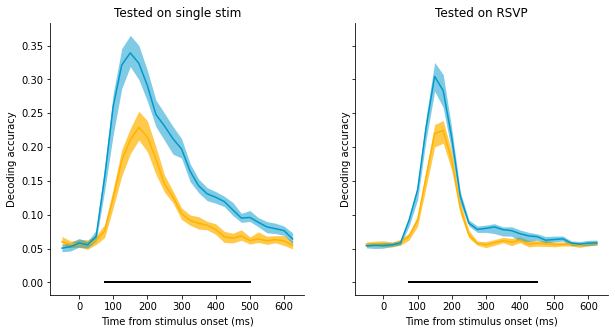

In [ ]:
nperm = 2000
fig,ax = plt.subplots(1,2,figsize = (10,5),sharey = True)

real_diff = accuracy_PPC_single_stim-accuracy_PFC_single_stim
permutdiff = np.zeros((nperm,real_diff.shape[1]))
for i in range(nperm):
    permutdiff[i,:] = abs(np.mean(np.matlib.repmat(np.sign(np.random.rand(real_diff.shape[0])-.5),real_diff.shape[1],1).transpose()*real_diff))
sigpoints = cluster_perm(abs(np.mean(real_diff,axis = 0)),permutdiff,.001,.001)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50

high_bound = np.sort(accuracy_PPC_single_stim,axis = 0)[49,:]
low_bound = np.sort(accuracy_PPC_single_stim,axis = 0)[1,:]
ax[0].fill_between(t,high_bound,low_bound,alpha= 0.7,linewidth = 0,color = [1,0.7,0])
ax[0].plot(t,np.mean(accuracy_PPC_single_stim, axis = 0),color = [1,0.7,0])

high_bound = np.sort(accuracy_PFC_single_stim,axis = 0)[49,:]
low_bound = np.sort(accuracy_PFC_single_stim,axis = 0)[1,:]
ax[0].fill_between(t,high_bound,low_bound,alpha= 0.5,linewidth = 0,color = [0,0.6,0.8])
ax[0].plot(t,np.mean(accuracy_PFC_single_stim, axis = 0),color = [0,0.6,0.8])

clusters = label(sigpoints)
for k in np.arange(1,max(clusters)+1):
    ax[0].plot(t[clusters==k],np.ones(sum(clusters==k))*0, color = 'k',linewidth = 2) 

ax[0].set_xlabel('Time from stimulus onset (ms)')
ax[0].set_ylabel('Decoding accuracy')
ax[0].set_title('Tested on single stim')


## Plot the accuracy on the RSVP condition
real_diff = accuracy_PPC_RSVP-accuracy_PFC_RSVP
permutdiff = np.zeros((nperm,real_diff.shape[1]))
for i in range(nperm):
    permutdiff[i,:] = abs(np.mean(np.matlib.repmat(np.sign(np.random.rand(real_diff.shape[0])-.5),real_diff.shape[1],1).transpose()*real_diff))
sigpoints = cluster_perm(abs(np.mean(real_diff,axis = 0)),permutdiff,.001,.001)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50


high_bound = np.sort(accuracy_PPC_RSVP,axis = 0)[49,:]
low_bound = np.sort(accuracy_PPC_RSVP,axis = 0)[1,:]
ax[1].fill_between(t,high_bound,low_bound,alpha= 0.7,linewidth = 0,color = [1,0.7,0])
ax[1].plot(t,np.mean(accuracy_PPC_RSVP, axis = 0),color = [1,0.7,0])

high_bound = np.sort(accuracy_PFC_RSVP,axis = 0)[49,:]
low_bound = np.sort(accuracy_PFC_RSVP,axis = 0)[1,:]
ax[1].fill_between(t,high_bound,low_bound,alpha= 0.5,linewidth = 0,color = [0,0.6,0.8])
ax[1].plot(t,np.mean(accuracy_PFC_RSVP, axis = 0),color = [0,0.6,0.8])

clusters = label(sigpoints)
for k in np.arange(1,max(clusters)+1):
    ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*0, color = 'k',linewidth = 2) 

ax[1].set_xlabel('Time from stimulus onset (ms)')
ax[1].set_ylabel('Decoding accuracy')
ax[1].set_title('Tested on RSVP')
sb.despine()
fig.savefig('monkeyA_PFC_VS_PPC_single_stim_decoders.pdf')

# Estimate difference in accuracy between PFC and PPC for stimuli in RSVP sequences

In [ ]:
nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
nperm = 50;
K = 10 # number of training folds
# index

accuracy_PPC_single_stim = np.zeros((nperm,len(t)))
accuracy_PPC_RSVP = np.zeros((nperm,len(t)))
accuracy_PFC_single_stim = np.zeros((nperm,len(t)))
accuracy_PFC_RSVP = np.zeros((nperm,len(t)))

nbins = len(t) # number of time bins
     
Y = np.array(df.StimID).astype(int)

for perm in tqdm(range(nperm)):
    selected_chan = np.where(outPPC.astype(bool))[0];
    selected_chan = selected_chan[np.random.permutation(len(selected_chan))][:maximal_chan_num-left_out]
    
    
    training_stims = RSVP

    X = PPC_Rc[:,selected_chan,:] # The firing rate
    
    ntr = X.shape[0]
    ntest = int(ntr/K)
    shuffle = np.random.permutation(ntr)# permutation of every trial
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    for k in range(K):
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
    all_single_stim = np.zeros((18,len(t)))
    all_RSVP  = np.zeros((18,len(t)))
    for n in stims:
        # in isolation
        isolated = np.argmax(Proba[(df.StimID == n) & single_stim,:],axis = 1) == n
        all_single_stim[n,:] = np.mean(isolated, axis = 0)
        # in RSVP
        inRSVP = np.argmax(Proba[(df.StimID == n) & RSVP,:],axis = 1) == n
        all_RSVP[n,:] = np.mean(inRSVP, axis = 0)
    accuracy_PPC_single_stim[perm,:] = np.mean(all_single_stim,axis = 0)
    accuracy_PPC_RSVP[perm,:] = np.mean(all_RSVP,axis = 0)
    
    # PFC accuracy
    X = Rc[:,selected_chan,:] # The firing rate
    ntr = X.shape[0]
    ntest = int(ntr/K)
    
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    for k in range(K):
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
    all_single_stim = np.zeros((18,len(t)))
    all_RSVP  = np.zeros((18,len(t)))
    for n in stims:
        # in isolation
        isolated = np.argmax(Proba[(df.StimID == n) & single_stim,:],axis = 1) == n
        all_single_stim[n,:] = np.mean(isolated, axis = 0)
        # in RSVP
        inRSVP = np.argmax(Proba[(df.StimID == n) & RSVP,:],axis = 1) == n
        all_RSVP[n,:] = np.mean(inRSVP, axis = 0)
    accuracy_PFC_single_stim[perm,:] = np.mean(all_single_stim,axis = 0)
    accuracy_PFC_RSVP[perm,:] = np.mean(all_RSVP,axis = 0)

100%|██████████| 50/50 [1:43:13<00:00, 123.86s/it]


## Figure S5 E and F

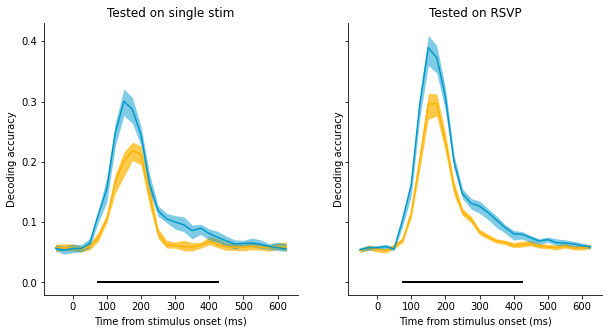

In [ ]:
nperm = 2000
fig,ax = plt.subplots(1,2,figsize = (10,5),sharey = True)

real_diff = accuracy_PPC_single_stim-accuracy_PFC_single_stim
permutdiff = np.zeros((nperm,real_diff.shape[1]))
for i in range(nperm):
    permutdiff[i,:] = abs(np.mean(np.matlib.repmat(np.sign(np.random.rand(real_diff.shape[0])-.5),real_diff.shape[1],1).transpose()*real_diff))
sigpoints = cluster_perm(abs(np.mean(real_diff,axis = 0)),permutdiff,.001,.001)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50

high_bound = np.sort(accuracy_PPC_single_stim,axis = 0)[49,:]
low_bound = np.sort(accuracy_PPC_single_stim,axis = 0)[1,:]
ax[0].fill_between(t,high_bound,low_bound,alpha= 0.7,linewidth = 0,color = [1,0.7,0])
ax[0].plot(t,np.mean(accuracy_PPC_single_stim, axis = 0),color = [1,0.7,0])

high_bound = np.sort(accuracy_PFC_single_stim,axis = 0)[49,:]
low_bound = np.sort(accuracy_PFC_single_stim,axis = 0)[1,:]
ax[0].fill_between(t,high_bound,low_bound,alpha= 0.5,linewidth = 0,color = [0,0.6,0.8])
ax[0].plot(t,np.mean(accuracy_PFC_single_stim, axis = 0),color = [0,0.6,0.8])

clusters = label(sigpoints)
for k in np.arange(1,max(clusters)+1):
    ax[0].plot(t[clusters==k],np.ones(sum(clusters==k))*0, color = 'k',linewidth = 2) 

ax[0].set_xlabel('Time from stimulus onset (ms)')
ax[0].set_ylabel('Decoding accuracy')
ax[0].set_title('Tested on single stim')


## Plot the accuracy on the RSVP condition
real_diff = accuracy_PPC_RSVP-accuracy_PFC_RSVP
permutdiff = np.zeros((nperm,real_diff.shape[1]))
for i in range(nperm):
    permutdiff[i,:] = abs(np.mean(np.matlib.repmat(np.sign(np.random.rand(real_diff.shape[0])-.5),real_diff.shape[1],1).transpose()*real_diff))
sigpoints = cluster_perm(abs(np.mean(real_diff,axis = 0)),permutdiff,.001,.001)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50


high_bound = np.sort(accuracy_PPC_RSVP,axis = 0)[49,:]
low_bound = np.sort(accuracy_PPC_RSVP,axis = 0)[1,:]
ax[1].fill_between(t,high_bound,low_bound,alpha= 0.7,linewidth = 0,color = [1,0.7,0])
ax[1].plot(t,np.mean(accuracy_PPC_RSVP, axis = 0),color = [1,0.7,0])

high_bound = np.sort(accuracy_PFC_RSVP,axis = 0)[49,:]
low_bound = np.sort(accuracy_PFC_RSVP,axis = 0)[1,:]
ax[1].fill_between(t,high_bound,low_bound,alpha= 0.5,linewidth = 0,color = [0,0.6,0.8])
ax[1].plot(t,np.mean(accuracy_PFC_RSVP, axis = 0),color = [0,0.6,0.8])

clusters = label(sigpoints)
for k in np.arange(1,max(clusters)+1):
    ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*0, color = 'k',linewidth = 2) 

ax[1].set_xlabel('Time from stimulus onset (ms)')
ax[1].set_ylabel('Decoding accuracy')
ax[1].set_title('Tested on RSVP')
sb.despine()
fig.savefig('monkeyA_PFC_VS_PPC_RSVP_decoders.pdf')